<a href="https://colab.research.google.com/github/haris-lutafullah/Research-Work/blob/main/Traffic_Prediction_System_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**Importing Library Files**</p>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import warnings



#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**Pre-Processing**</p>

Correlation Matrix:
                      holiday      temp   rain_1h   snow_1h  clouds_all  \
holiday              1.000000  0.004646  0.000177  0.000863    0.007506   
temp                 0.004646  1.000000  0.009069 -0.019755   -0.101976   
rain_1h              0.000177  0.009069  1.000000 -0.000090    0.004818   
snow_1h              0.000863 -0.019755 -0.000090  1.000000    0.027931   
clouds_all           0.007506 -0.101976  0.004818  0.027931    1.000000   
weather_main        -0.001831 -0.033441  0.009535  0.036637    0.500745   
weather_description  0.000485 -0.049434  0.010774  0.005101   -0.341891   
traffic_volume       0.038057  0.130299  0.004714  0.000733    0.067054   

                     weather_main  weather_description  traffic_volume  
holiday                 -0.001831             0.000485        0.038057  
temp                    -0.033441            -0.049434        0.130299  
rain_1h                  0.009535             0.010774        0.004714  
snow_1h     

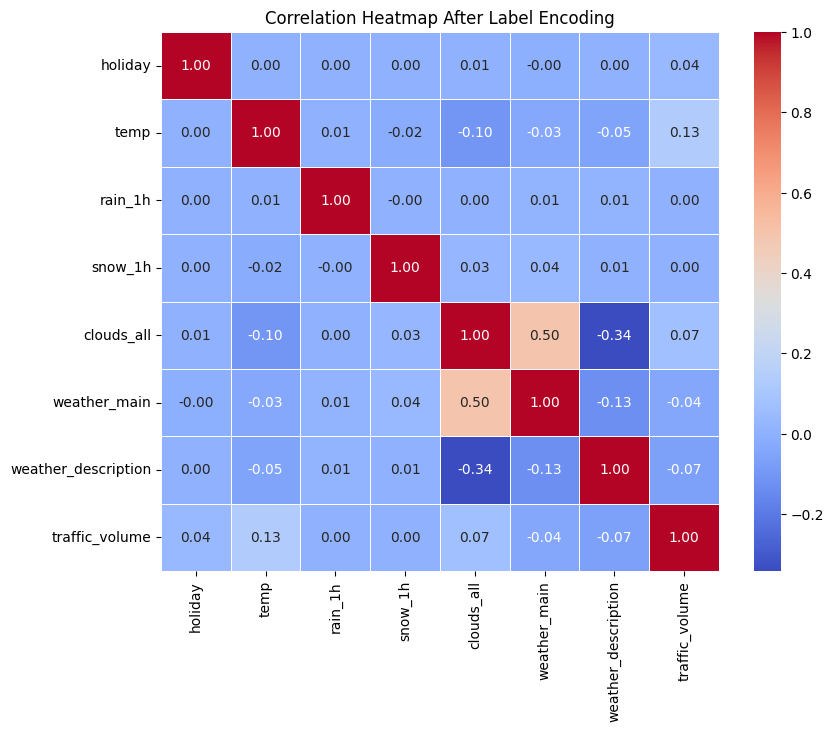

ADF Statistic: -28.019967663217848
p-value: 0.0
Critical Values: {'1%': np.float64(-3.4304858126067175), '5%': np.float64(-2.8616000263321806), '10%': np.float64(-2.566801950040208)}

✅ Series is stationary


In [33]:

df = pd.read_csv("Metro_Interstate_Traffic_Volume.csv")
df['date_time'] = pd.to_datetime(df['date_time'])
df.set_index('date_time', inplace=True)

# Label Encoding
label_encoders = {}
categorical_cols = ['holiday', 'weather_main', 'weather_description']
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Handle outliers using IQR
Q1 = df['traffic_volume'].quantile(0.25)
Q3 = df['traffic_volume'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df['traffic_volume'] >= lower_bound) & (df['traffic_volume'] <= upper_bound)]


# Compute correlation matrix
correlation_matrix = df.corr()

# Display the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Plot heatmap
plt.figure(figsize=(9, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap After Label Encoding")
plt.show()

# Create lag features
for lag in range(1, 4):  # 3 lag features
    df[f'lag_{lag}'] = df['traffic_volume'].shift(lag)
df.dropna(inplace=True)

# Normalize features
scaler = MinMaxScaler()
df[df.columns] = scaler.fit_transform(df)
traffic_scaler = MinMaxScaler()
df['traffic_volume'] = traffic_scaler.fit_transform(df[['traffic_volume']])

# ADF test
adf_result = adfuller(df['traffic_volume'])
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical Values:", adf_result[4])

if adf_result[1] < 0.05:
    print("\n✅ Series is stationary")
else:
    print("\n❌ Series is NOT stationary")
# Train-test split
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]
X_train, y_train = train.drop(columns=['traffic_volume']), train['traffic_volume']
X_test, y_test = test.drop(columns=['traffic_volume']), test['traffic_volume']

# Convert to PyTorch tensors
X_train_torch, y_train_torch = torch.tensor(X_train.values, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32)
X_test_torch, y_test_torch = torch.tensor(X_test.values, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.float32)


#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**LSTM Model Implementation and Training**</p>

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 31s 36ms/step - loss: 0.0692 - val_loss: 0.0263
Epoch 2/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - loss: 0.0311 - val_loss: 0.0136
Epoch 3/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 19s 32ms/step - loss: 0.0176 - val_loss: 0.0083
Epoch 4/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - loss: 0.0125 - val_loss: 0.0060
Epoch 5/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - loss: 0.0112 - val_loss: 0.0059
Epoch 6/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 19s 32ms/step - loss: 0.0103 - val_loss: 0.0056
Epoch 7/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 22s 34ms/step - loss: 0.0096 - val_loss: 0.0052
Epoch 8/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 40s 33ms/step - loss: 0.0093 - val_loss: 0.0056
Epoch 9/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 25s 41ms/step - loss: 0.0092 - val_loss: 0.0050
Epoch 10/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 35s 31ms/step - loss: 0.0088 - val_loss: 0.0046
Epoch 11/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 23s 36ms/step - loss: 0.0087 - val_loss: 0.0046
Epoch 12/20
603/603 ━━━━━━━━━━

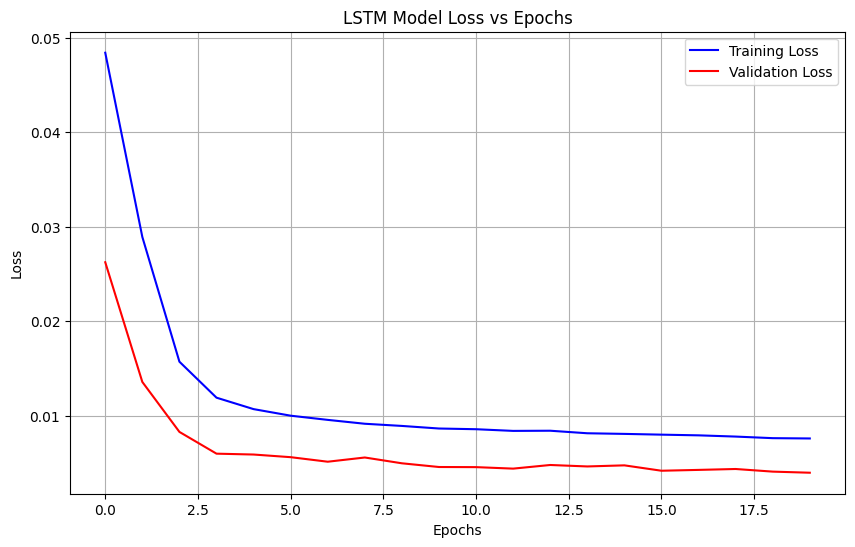

In [5]:
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
history = lstm_model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test))

# LSTM Predictions
y_pred_lstm = lstm_model.predict(X_test)
y_pred_lstm = traffic_scaler.inverse_transform(y_pred_lstm.reshape(-1, 1)).flatten()
y_test_inv = traffic_scaler.inverse_transform(y_test.values.reshape(-1, 1)).flatten()

# Plot the training & validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('LSTM Model Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**ARIMA Model Implementation and Training**</p>

In [6]:

#train_arima, test_arima = df['traffic_volume'][:train_size], df['traffic_volume'][train_size:]
#model_arima = ARIMA(train_arima, order=(5, 1, 0))
#model_arima_fit = model_arima.fit()
#y_pred_arima = model_arima_fit.forecast(steps=len(test_arima))
#y_pred_arima = y_pred_arima[:len(y_test_inv)]


train_arima, test_arima = df['traffic_volume'][:train_size], df['traffic_volume'][train_size:]

# Grid Search for best (p, d, q)
best_aic = float("inf")
best_order = None
best_model_fit = None

# Define range for p, d, q
p_values = range(0, 4)
d_values = range(0, 3)
q_values = range(0, 4)

for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                model = ARIMA(train_arima, order=(p, d, q))
                model_fit = model.fit()
                aic = model_fit.aic
                if aic < best_aic:
                    best_aic = aic
                    best_order = (p, d, q)
                    best_model_fit = model_fit
            except:
                continue

print(f"Best ARIMA Order: {best_order} with AIC: {best_aic}")

# Forecast using best model
y_pred_arima = best_model_fit.forecast(steps=len(test_arima)).to_numpy()
# Align length just in case
y_pred_arima = y_pred_arima[:len(test_arima)]

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Best ARIMA Order: (3, 0, 3) with AIC: -68260.98528260602


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**TSMixer Model Implementation and Training**</p>

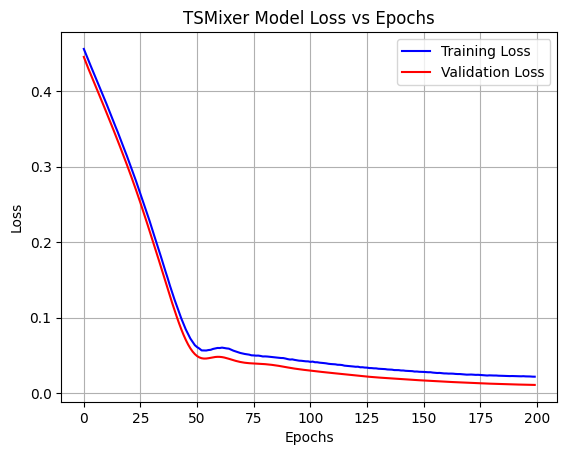

In [10]:
# TSMixer Model Definition
class TSMixer(nn.Module):
    def __init__(self, input_dim):
        super(TSMixer, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        return self.fc4(x)

# Initialize the model
tsmixer_model = TSMixer(X_train_torch.shape[1])
criterion = nn.MSELoss()
optimizer = optim.AdamW(tsmixer_model.parameters(), lr=0.0003, weight_decay=1e-4)

train_losses = []
val_losses = []

# Training loop with validation and loss tracking
for epoch in range(200):
    tsmixer_model.train()  # Set model to training mode
    optimizer.zero_grad()  # Clear the gradients
    outputs = tsmixer_model(X_train_torch).squeeze()  # Forward pass
    loss = criterion(outputs, y_train_torch)  # Compute training loss
    loss.backward()  # Backpropagation
    optimizer.step()  # Update model parameters

    # Track training loss
    train_losses.append(loss.item())

    # Validation loss
    tsmixer_model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # No need to compute gradients for validation
        val_outputs = tsmixer_model(X_test_torch).squeeze()
        val_loss = criterion(val_outputs, y_test_torch)

    # Track validation loss
    val_losses.append(val_loss.item())

# Plotting the training and validation loss over epochs
plt.plot(range(200), train_losses, label='Training Loss', color='blue')
plt.plot(range(200), val_losses, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('TSMixer Model Loss vs Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Making predictions with the trained TSMixer model
y_pred_tsmixer = tsmixer_model(X_test_torch).detach().numpy().flatten()
y_pred_tsmixer = traffic_scaler.inverse_transform(y_pred_tsmixer.reshape(-1, 1)).flatten()

#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**Hybrid LSTM and TSMixer Model Implementation and Training**</p>

In [34]:
# ========================
# 1 DEFINE LSTM MODEL
# ========================
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.3)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x, _ = self.lstm(x.unsqueeze(1))  # Add batch dimension
        x = self.fc(x[:, -1, :])
        return x

lstm_model = LSTMModel(X_train.shape[1])

Epoch [10/300], Loss: 0.0093
Epoch [20/300], Loss: 0.0080
Epoch [30/300], Loss: 0.0074
Epoch [40/300], Loss: 0.0072
Epoch [50/300], Loss: 0.0070
Epoch [60/300], Loss: 0.0069
Epoch [70/300], Loss: 0.0067
Epoch [80/300], Loss: 0.0067
Epoch [90/300], Loss: 0.0065
Epoch [100/300], Loss: 0.0065
Epoch [110/300], Loss: 0.0064
Epoch [120/300], Loss: 0.0064
Epoch [130/300], Loss: 0.0063
Epoch [140/300], Loss: 0.0063
Epoch [150/300], Loss: 0.0062
Epoch [160/300], Loss: 0.0063
Epoch [170/300], Loss: 0.0062
Epoch [180/300], Loss: 0.0062
Epoch [190/300], Loss: 0.0061
Epoch [200/300], Loss: 0.0061
Epoch [210/300], Loss: 0.0061
Epoch [220/300], Loss: 0.0061
Epoch [230/300], Loss: 0.0061
Epoch [240/300], Loss: 0.0060
Epoch [250/300], Loss: 0.0060
Epoch [260/300], Loss: 0.0060
Epoch [270/300], Loss: 0.0060
Epoch [280/300], Loss: 0.0060
Epoch [290/300], Loss: 0.0060
Epoch [300/300], Loss: 0.0059


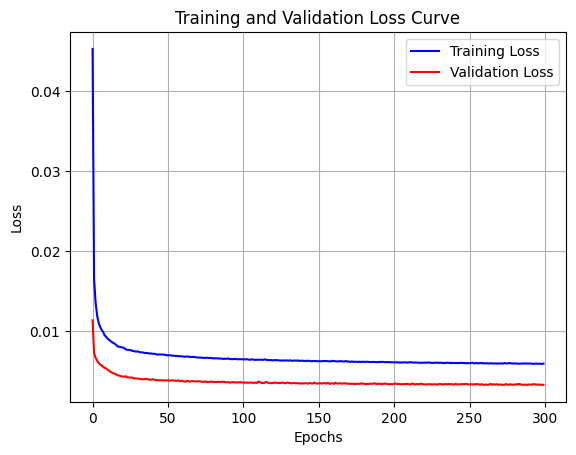

In [35]:
# ========================
# 2 DEFINE TSMixer MODEL
# ========================
class TSMixer(nn.Module):
    def __init__(self, input_dim):
        super(TSMixer, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        return self.fc4(x)

tsmixer_model = TSMixer(X_train.shape[1])
# ========================
# 3 HYBRID MODEL (LSTM + TSMixer)
# ========================
class HybridModel(nn.Module):
    def __init__(self, input_dim):
        super(HybridModel, self).__init__()
        self.lstm = LSTMModel(input_dim)
        self.tsmixer = TSMixer(input_dim)
        self.fc = nn.Linear(2, 1)  # Combine both outputs

    def forward(self, x):
        lstm_out = self.lstm(x)
        tsmixer_out = self.tsmixer(x)
        combined = torch.cat((lstm_out, tsmixer_out), dim=1)
        return self.fc(combined)

hybrid_model = HybridModel(X_train.shape[1])
# ========================
# 4 TRAINING
# ========================
criterion = nn.MSELoss()
optimizer = optim.AdamW(hybrid_model.parameters(), lr=0.0001, weight_decay=1e-4)

batch_size = 64
num_epochs = 300

train_dataset = torch.utils.data.TensorDataset(X_train_torch, y_train_torch)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    hybrid_model.train()
    epoch_loss = 0

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = hybrid_model(batch_X).squeeze()
        loss = criterion(outputs, batch_y.squeeze())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_loader))  # Store training loss

    # **Validation Loss Calculation (added)**
    hybrid_model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        val_outputs = hybrid_model(X_test_torch).squeeze()  # Make predictions on test data
        val_loss = criterion(val_outputs, y_test_torch)
        val_losses.append(val_loss.item())  # Store validation loss

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}")

# **Plotting the loss curves (added)**
plt.plot(range(num_epochs), train_losses, label='Training Loss', color='blue')
plt.plot(range(num_epochs), val_losses, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**hybrid KNN LSTM Implementation and Training**</p>

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1205/1205 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.0561 - val_loss: 0.0045
Epoch 2/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0087 - val_loss: 0.0044
Epoch 3/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0076 - val_loss: 0.0046
Epoch 4/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0072 - val_loss: 0.0044
Epoch 5/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.0069 - val_loss: 0.0044
Epoch 6/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0068 - val_loss: 0.0044
Epoch 7/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0066 - val_loss: 0.0043
Epoch 8/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0069 - val_loss: 0.0043
Epoch 9/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0068 - val_loss: 0.0043
Epoch 10/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0067 - val_loss: 0.0043


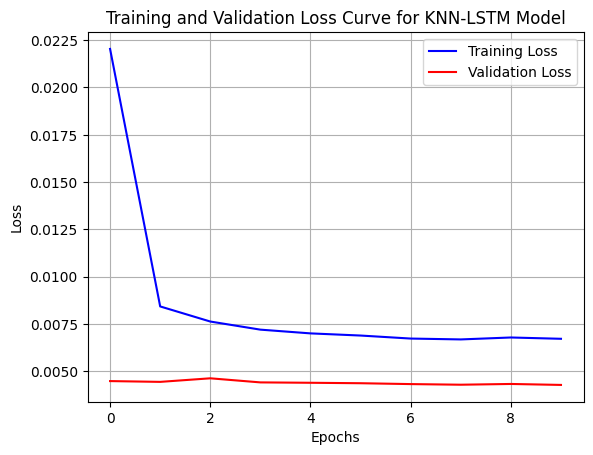

302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [16]:
# ========================
#  KNN MODEL FOR FEATURE SELECTION
# ========================
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)
X_train_knn = knn.predict(X_train).reshape(-1, 1)
X_test_knn = knn.predict(X_test).reshape(-1, 1)

# ========================
#  KNN-LSTM MODEL
# ========================
def build_knn_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, activation='relu', return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(50, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Reshape for LSTM
X_train_knn_lstm = np.reshape(X_train_knn, (X_train_knn.shape[0], 1, 1))
X_test_knn_lstm = np.reshape(X_test_knn, (X_test_knn.shape[0], 1, 1))

knn_lstm_model = build_knn_lstm_model((1, 1))

# **Updated Part: Added validation and loss curve tracking**
history = knn_lstm_model.fit(X_train_knn_lstm, y_train, epochs=10, batch_size=32, verbose=1, validation_data=(X_test_knn_lstm, y_test))

# **Plotting the training and validation loss curves (added)**
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve for KNN-LSTM Model')
plt.legend()
plt.grid(True)
plt.show()

y_pred_knn_lstm = knn_lstm_model.predict(X_test_knn_lstm)

# Rescale predictions back to original scale
y_pred_knn_lstm = traffic_scaler.inverse_transform(y_pred_knn_lstm)
y_test_rescaled = traffic_scaler.inverse_transform(y_test.values.reshape(-1, 1)).flatten()


#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**DASNet Model Implementation and Training**</p>

Epoch 1/20, Loss: 0.0257
Epoch 2/20, Loss: 0.0096
Epoch 3/20, Loss: 0.0092
Epoch 4/20, Loss: 0.0089
Epoch 5/20, Loss: 0.0087
Epoch 6/20, Loss: 0.0086
Epoch 7/20, Loss: 0.0084
Epoch 8/20, Loss: 0.0081
Epoch 9/20, Loss: 0.0080
Epoch 10/20, Loss: 0.0077
Epoch 11/20, Loss: 0.0076
Epoch 12/20, Loss: 0.0075
Epoch 13/20, Loss: 0.0074
Epoch 14/20, Loss: 0.0074
Epoch 15/20, Loss: 0.0073
Epoch 16/20, Loss: 0.0073
Epoch 17/20, Loss: 0.0072
Epoch 18/20, Loss: 0.0071
Epoch 19/20, Loss: 0.0071
Epoch 20/20, Loss: 0.0071


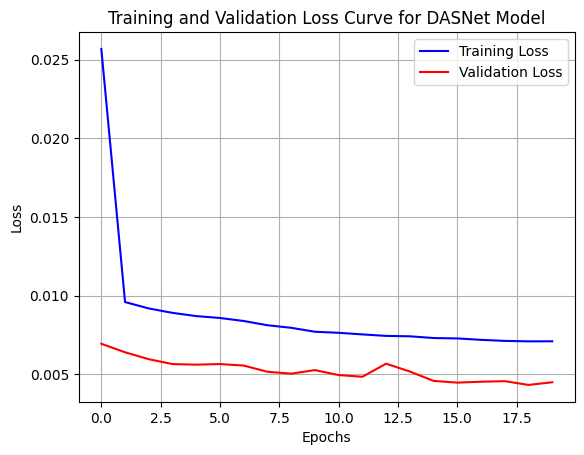

In [17]:
# ========================
#  IMPLEMENT DASNet
# ========================
class DASNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2):
        super(DASNet, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.attention = nn.Linear(hidden_dim, 1)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        attn_weights = torch.softmax(self.attention(lstm_out), dim=1)
        context = torch.sum(attn_weights * lstm_out, dim=1)
        out = self.fc(context)
        return out.squeeze()

# Model setup
input_dim = X_train_torch.shape[1]
dasnet = DASNet(input_dim)

criterion = nn.MSELoss()
optimizer = optim.Adam(dasnet.parameters(), lr=0.001)

# Prepare data for training
train_dataset = TensorDataset(X_train_torch.unsqueeze(1), y_train_torch)
test_dataset = TensorDataset(X_test_torch.unsqueeze(1), y_test_torch)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# **Updated Part: Added loss and validation curve tracking**
train_losses = []  # Track training losses
val_losses = []  # Track validation losses

# Training loop
epochs = 20
for epoch in range(epochs):
    dasnet.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = dasnet(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    train_losses.append(epoch_loss / len(train_loader))  # Store training loss

    # **Validation loss calculation (added)**
    dasnet.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            y_pred = dasnet(X_batch)
            val_loss += criterion(y_pred, y_batch).item()
    val_losses.append(val_loss / len(test_loader))  # Store validation loss

    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.4f}')

# **Plotting the loss curves (added)**
plt.plot(range(epochs), train_losses, label='Training Loss', color='blue')
plt.plot(range(epochs), val_losses, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve for DASNet Model')
plt.legend()
plt.grid(True)
plt.show()

# ========================
#  EVALUATION (UPDATED)
# ========================
dasnet.eval()
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_pred = dasnet(X_batch)
        y_pred_list.append(y_pred.numpy())
        y_true_list.append(y_batch.numpy())

y_pred_list = np.concatenate(y_pred_list)
y_true_list = np.concatenate(y_true_list)

# Convert back to original scale
y_pred_actual_Dasnet = traffic_scaler.inverse_transform(y_pred_list.reshape(-1, 1))
y_true_actual = traffic_scaler.inverse_transform(y_true_list.reshape(-1, 1))


#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**DASNet LSTM Model Implementation and Training**</p>

In [ ]:
# Define GCN Layer
class GCNLayer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(GCNLayer, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x, adj):
        x = torch.matmul(adj, x.T).T  # Fix dimension mismatch
        return torch.relu(self.fc(x))

# Define DASNet-LSTM Model
class DASNetLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, lstm_units, adj_matrix):
        super(DASNetLSTM, self).__init__()
        self.adj = torch.tensor(adj_matrix, dtype=torch.float32)
        self.gcn = GCNLayer(input_dim, hidden_dim)
        self.attn = nn.Linear(hidden_dim, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, lstm_units, batch_first=True)
        self.fc = nn.Linear(lstm_units, 1)

    def forward(self, x):
        x = self.gcn(x, self.adj)
        attn_weights = torch.softmax(self.attn(x), dim=1)
        x = x * attn_weights  # Apply attention
        x = x.unsqueeze(1)  # LSTM expects (batch, seq_len, features)
        x, _ = self.lstm(x)
        return self.fc(x[:, -1, :])  # Final output

# Adjacency matrix (Identity as placeholder)
adj_matrix = np.eye(X_train.shape[1])


In [ ]:
model = DASNetLSTM(input_dim=X_train.shape[1], hidden_dim=64, lstm_units=32, adj_matrix=adj_matrix)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
# Training loop
num_epochs = 600

# Convert X_train to a PyTorch tensor before feeding it into the model
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)  # Also convert y_train for consistency

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor).squeeze() # Pass the tensor here
    loss = criterion(outputs, y_train_tensor) # Pass the tensor here
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [10/600], Loss: 0.2025
Epoch [20/600], Loss: 0.1757
Epoch [30/600], Loss: 0.1504
Epoch [40/600], Loss: 0.1255
Epoch [50/600], Loss: 0.1007
Epoch [60/600], Loss: 0.0796
Epoch [70/600], Loss: 0.0678
Epoch [80/600], Loss: 0.0643
Epoch [90/600], Loss: 0.0624
Epoch [100/600], Loss: 0.0587
Epoch [110/600], Loss: 0.0536
Epoch [120/600], Loss: 0.0469
Epoch [130/600], Loss: 0.0401
Epoch [140/600], Loss: 0.0347
Epoch [150/600], Loss: 0.0310
Epoch [160/600], Loss: 0.0285
Epoch [170/600], Loss: 0.0263
Epoch [180/600], Loss: 0.0242
Epoch [190/600], Loss: 0.0219
Epoch [200/600], Loss: 0.0196
Epoch [210/600], Loss: 0.0172
Epoch [220/600], Loss: 0.0150
Epoch [230/600], Loss: 0.0132
Epoch [240/600], Loss: 0.0119
Epoch [250/600], Loss: 0.0112
Epoch [260/600], Loss: 0.0109
Epoch [270/600], Loss: 0.0106
Epoch [280/600], Loss: 0.0104
Epoch [290/600], Loss: 0.0103
Epoch [300/600], Loss: 0.0102
Epoch [310/600], Loss: 0.0101
Epoch [320/600], Loss: 0.0100
Epoch [330/600], Loss: 0.0099
Epoch [340/600], Lo

In [ ]:
# Evaluate model
model.eval()
# Convert X_test to a PyTorch tensor before feeding it into the model
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32) # Convert X_test to Tensor
y_pred_Dasnet_LSTM = model(X_test_tensor).detach().numpy() # Pass the tensor to the model


Epoch [10/300] | Train Loss: 0.3077 | Val Loss: 0.3017
Epoch [20/300] | Train Loss: 0.2737 | Val Loss: 0.2678
Epoch [30/300] | Train Loss: 0.2399 | Val Loss: 0.2340
Epoch [40/300] | Train Loss: 0.2045 | Val Loss: 0.1983
Epoch [50/300] | Train Loss: 0.1660 | Val Loss: 0.1594
Epoch [60/300] | Train Loss: 0.1257 | Val Loss: 0.1191
Epoch [70/300] | Train Loss: 0.0903 | Val Loss: 0.0848
Epoch [80/300] | Train Loss: 0.0680 | Val Loss: 0.0642
Epoch [90/300] | Train Loss: 0.0599 | Val Loss: 0.0574
Epoch [100/300] | Train Loss: 0.0577 | Val Loss: 0.0552
Epoch [110/300] | Train Loss: 0.0540 | Val Loss: 0.0512
Epoch [120/300] | Train Loss: 0.0501 | Val Loss: 0.0472
Epoch [130/300] | Train Loss: 0.0465 | Val Loss: 0.0435
Epoch [140/300] | Train Loss: 0.0432 | Val Loss: 0.0399
Epoch [150/300] | Train Loss: 0.0400 | Val Loss: 0.0365
Epoch [160/300] | Train Loss: 0.0369 | Val Loss: 0.0333
Epoch [170/300] | Train Loss: 0.0339 | Val Loss: 0.0302
Epoch [180/300] | Train Loss: 0.0312 | Val Loss: 0.0274
E

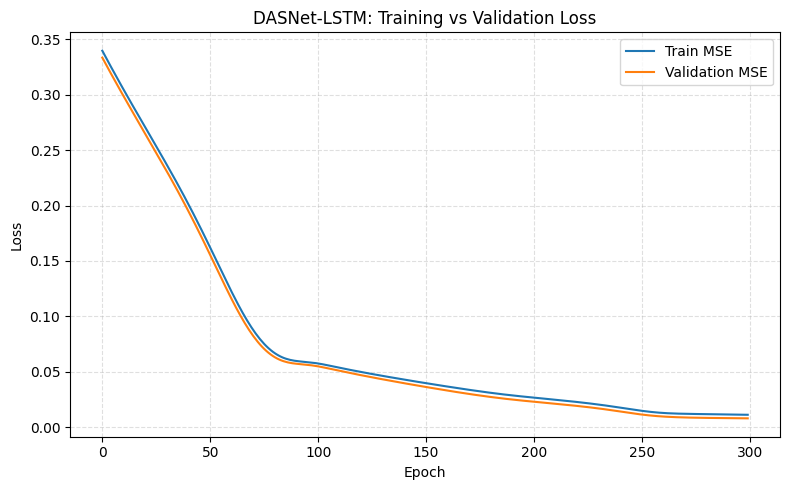

In [18]:

# -------------------------
# GCN layer
# -------------------------
class GCNLayer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x, adj):
        # x: [batch, feat], adj: [feat, feat]
        x = torch.matmul(adj, x.T).T
        return torch.relu(self.fc(x))

# -------------------------
# DASNet-LSTM
# -------------------------
class DASNetLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, lstm_units, adj_matrix):
        super().__init__()
        # register adj so it follows .to(device)
        self.register_buffer("adj", torch.tensor(adj_matrix, dtype=torch.float32))
        self.gcn  = GCNLayer(input_dim, hidden_dim)
        self.attn = nn.Linear(hidden_dim, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, lstm_units, batch_first=True)
        self.fc   = nn.Linear(lstm_units, 1)

    def forward(self, x):
        x = self.gcn(x, self.adj)                 # [batch, hidden_dim]
        attn_weights = torch.softmax(self.attn(x), dim=1)  # [batch, hidden_dim]
        x = x * attn_weights
        x = x.unsqueeze(1)                         # [batch, 1, hidden_dim]
        x, _ = self.lstm(x)                        # [batch, 1, lstm_units]
        out = self.fc(x[:, -1, :])                 # [batch, 1]
        return out.squeeze(-1)                     # [batch]

# -------------------------
# Setup
# -------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_dim   = X_train.shape[1]
adj_matrix  = np.eye(input_dim)

model = DASNetLSTM(input_dim=input_dim, hidden_dim=64, lstm_units=32, adj_matrix=adj_matrix).to(device)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

# Tensors + shapes
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values,  dtype=torch.float32).view(-1).to(device)
X_test_tensor  = torch.tensor(X_test.values,  dtype=torch.float32).to(device)
y_test_tensor  = torch.tensor(y_test.values,   dtype=torch.float32).view(-1).to(device)

# -------------------------
# Train (with validation)
# -------------------------
num_epochs = 300
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    # validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_loss = criterion(val_outputs, y_test_tensor)

    train_losses.append(float(loss.item()))
    val_losses.append(float(val_loss.item()))

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f}")

# -------------------------
# Evaluate
# -------------------------
model.eval()
with torch.no_grad():
    y_pred_Dasnet_LSTM = model(X_test_tensor).detach().cpu().numpy()
    y_true             = y_test_tensor.detach().cpu().numpy()

# (Optional) inverse-scale outside if you need:
# y_pred_actual = traffic_scaler.inverse_transform(y_pred_Dasnet_LSTM.reshape(-1, 1)).flatten()
# y_true_actual = traffic_scaler.inverse_transform(y_true.reshape(-1, 1)).flatten()

# -------------------------
# Plot Train vs Validation Loss
# -------------------------
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train MSE")
plt.plot(val_losses, label="Validation MSE")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("DASNet-LSTM: Training vs Validation Loss")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**Implementing TimeMixer Model**</p>

Epoch [10/250] | Train Loss: 0.1431 | Test Loss: 0.1182
Epoch [20/250] | Train Loss: 0.0664 | Test Loss: 0.0456
Epoch [30/250] | Train Loss: 0.0408 | Test Loss: 0.0217
Epoch [40/250] | Train Loss: 0.0326 | Test Loss: 0.0150
Epoch [50/250] | Train Loss: 0.0295 | Test Loss: 0.0122
Epoch [60/250] | Train Loss: 0.0277 | Test Loss: 0.0110
Epoch [70/250] | Train Loss: 0.0263 | Test Loss: 0.0100
Epoch [80/250] | Train Loss: 0.0247 | Test Loss: 0.0094
Epoch [90/250] | Train Loss: 0.0233 | Test Loss: 0.0088
Epoch [100/250] | Train Loss: 0.0222 | Test Loss: 0.0085
Epoch [110/250] | Train Loss: 0.0212 | Test Loss: 0.0082
Epoch [120/250] | Train Loss: 0.0204 | Test Loss: 0.0080
Epoch [130/250] | Train Loss: 0.0193 | Test Loss: 0.0078
Epoch [140/250] | Train Loss: 0.0187 | Test Loss: 0.0076
Epoch [150/250] | Train Loss: 0.0180 | Test Loss: 0.0074
Epoch [160/250] | Train Loss: 0.0176 | Test Loss: 0.0072
Epoch [170/250] | Train Loss: 0.0172 | Test Loss: 0.0071
Epoch [180/250] | Train Loss: 0.0167 | T

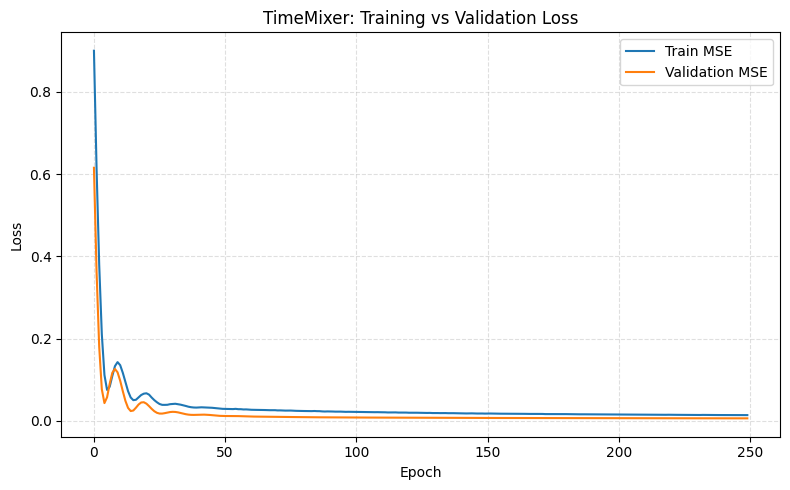

In [19]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# --- TimeMixer model ---
class TimeMixerBlock(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout=0.2):
        super(TimeMixerBlock, self).__init__()
        self.layernorm1 = nn.LayerNorm(input_dim)
        self.temporal_mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, input_dim),
        )
        self.layernorm2 = nn.LayerNorm(input_dim)
        self.channel_mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, input_dim),
        )

    def forward(self, x):
        x = x + self.temporal_mlp(self.layernorm1(x))
        x = x + self.channel_mlp(self.layernorm2(x))
        return x

class TimeMixer(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_blocks=3):
        super(TimeMixer, self).__init__()
        self.mixer_blocks = nn.Sequential(
            *[TimeMixerBlock(input_dim, hidden_dim) for _ in range(num_blocks)]
        )
        self.output_layer = nn.Linear(input_dim, 1)

    def forward(self, x):
        x = self.mixer_blocks(x)          # [batch, input_dim]
        x = self.output_layer(x)          # [batch, 1]
        return x.squeeze(-1)              # [batch]

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model, loss, optimizer
input_dim = X_train.shape[1]
model = TimeMixer(input_dim=input_dim).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Move data to device (+ ensure shapes)
X_train_torch = X_train_torch.to(device)
X_test_torch  = X_test_torch.to(device)
y_train_torch = y_train_torch.to(device).view(-1)  # ensure 1-D
y_test_torch  = y_test_torch.to(device).view(-1)   # ensure 1-D

# If inputs are 3D from earlier LSTM code, squeeze seq_len dimension -> [batch, input_dim]
if X_train_torch.dim() == 3 and X_train_torch.size(1) == 1:
    X_train_torch = X_train_torch.squeeze(1)
if X_test_torch.dim() == 3 and X_test_torch.size(1) == 1:
    X_test_torch = X_test_torch.squeeze(1)

# --- Track losses ---
train_losses, val_losses = [], []

# Training loop
epochs = 250
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_torch)
    loss = criterion(outputs, y_train_torch)
    loss.backward()
    optimizer.step()

    # validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_torch)
        val_loss = criterion(val_outputs, y_test_torch)

    train_losses.append(float(loss.item()))
    val_losses.append(float(val_loss.item()))

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {loss.item():.4f} | Test Loss: {val_loss.item():.4f}")

# Prediction
model.eval()
with torch.no_grad():
    y_pred_TimeMixer = model(X_test_torch).detach().cpu().numpy()
    y_true = y_test_torch.detach().cpu().numpy()

# --- Plot Train vs Validation Loss ---
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train MSE")
plt.plot(val_losses, label="Validation MSE")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("TimeMixer: Training vs Validation Loss")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**Hybrid TimeMixer-LSTM**</p>

Epoch [10/100] | Train Loss: 0.0667 | Test Loss: 0.0379
Epoch [20/100] | Train Loss: 0.0348 | Test Loss: 0.0192
Epoch [30/100] | Train Loss: 0.0244 | Test Loss: 0.0128
Epoch [40/100] | Train Loss: 0.0190 | Test Loss: 0.0089
Epoch [50/100] | Train Loss: 0.0155 | Test Loss: 0.0072
Epoch [60/100] | Train Loss: 0.0136 | Test Loss: 0.0066
Epoch [70/100] | Train Loss: 0.0127 | Test Loss: 0.0062
Epoch [80/100] | Train Loss: 0.0119 | Test Loss: 0.0060
Epoch [90/100] | Train Loss: 0.0115 | Test Loss: 0.0059
Epoch [100/100] | Train Loss: 0.0110 | Test Loss: 0.0058


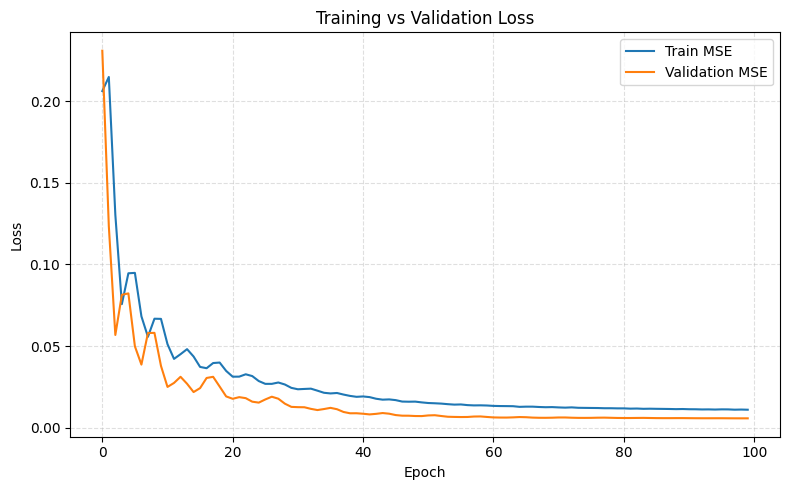

In [20]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Convert to PyTorch tensors
X_train_torch = torch.tensor(X_train.values, dtype=torch.float32)
X_test_torch  = torch.tensor(X_test.values,  dtype=torch.float32)
y_train_torch = torch.tensor(y_train.values, dtype=torch.float32).view(-1)  # ensure 1-D
y_test_torch  = torch.tensor(y_test.values,  dtype=torch.float32).view(-1)  # ensure 1-D

# Ensure input is 3D for LSTM: [batch, seq_len=1, input_dim]
if X_train_torch.dim() == 2:
    X_train_torch = X_train_torch.unsqueeze(1)
if X_test_torch.dim() == 2:
    X_test_torch = X_test_torch.unsqueeze(1)

# --- TimeMixer Block ---
class TimeMixerBlock(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout=0.2):
        super(TimeMixerBlock, self).__init__()
        self.layernorm1 = nn.LayerNorm(input_dim)
        self.temporal_mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, input_dim),
        )
        self.layernorm2 = nn.LayerNorm(input_dim)
        self.channel_mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, input_dim),
        )

    def forward(self, x):
        x = x + self.temporal_mlp(self.layernorm1(x))
        x = x + self.channel_mlp(self.layernorm2(x))
        return x

# --- Hybrid LSTM + TimeMixer Model ---
class HybridLSTMTimeMixer(nn.Module):
    def __init__(self, input_dim, lstm_hidden=64, tm_hidden=64, num_tm_blocks=2):
        super(HybridLSTMTimeMixer, self).__init__()
        self.lstm = nn.LSTM(input_dim, lstm_hidden, batch_first=True)
        self.tm_blocks = nn.Sequential(
            *[TimeMixerBlock(lstm_hidden, tm_hidden) for _ in range(num_tm_blocks)]
        )
        self.output_layer = nn.Linear(lstm_hidden, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)       # [batch, seq_len=1, lstm_hidden]
        x = lstm_out.squeeze(1)          # [batch, lstm_hidden]
        x = self.tm_blocks(x)            # TimeMixer blocks
        out = self.output_layer(x)       # [batch, 1]
        return out.squeeze(-1)           # [batch]

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model, Loss, Optimizer
input_dim = X_train.shape[1]
model = HybridLSTMTimeMixer(input_dim).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Move data to device
X_train_torch = X_train_torch.to(device)
X_test_torch  = X_test_torch.to(device)
y_train_torch = y_train_torch.to(device)
y_test_torch  = y_test_torch.to(device)

# --- NEW: Track losses ---
train_losses = []
val_losses = []

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_torch)
    loss = criterion(outputs, y_train_torch)
    loss.backward()
    optimizer.step()

    # --- NEW: validation every epoch & store losses ---
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_torch)
        val_loss = criterion(val_outputs, y_test_torch)

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {loss.item():.4f} | Test Loss: {val_loss.item():.4f}")

# Prediction
model.eval()
with torch.no_grad():
    y_pred_TimeMixer = model(X_test_torch).detach().cpu().numpy()
    y_true = y_test_torch.detach().cpu().numpy()

# Inverse transform to original scale
y_pred_TimeMixer_LSTM = traffic_scaler.inverse_transform(y_pred_TimeMixer.reshape(-1, 1)).flatten()
y_true_actual = traffic_scaler.inverse_transform(y_true.reshape(-1, 1)).flatten()

# --- NEW: Plot Train vs Validation Loss ---
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train MSE")
plt.plot(val_losses, label="Validation MSE")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**Evaluations metrics**</p>

In [36]:
# ========================
# 6⃣ MODEL EVALUATION
# ========================
hybrid_model.eval()
with torch.no_grad():
    # Reshape X_test_torch to 3D for LSTM
    y_test_pred = hybrid_model(X_test_torch.squeeze(1)).squeeze().numpy()  # Remove extra dimension

# Inverse transform predictions
y_test_pred_inv = traffic_scaler.inverse_transform(y_test_pred.reshape(-1, 1)).flatten()
y_test_actual_inv = traffic_scaler.inverse_transform(y_test_torch.numpy().reshape(-1, 1)).flatten()
# Metrics calculation
def mean_absolute_percentage_error(y_true, y_pred):
    non_zero_indices = y_true != 0  # Avoid division by zero
    return np.mean(np.abs((y_true[non_zero_indices] - y_pred[non_zero_indices]) / y_true[non_zero_indices])) * 100

def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return round(mse, 5), round(rmse, 5), round(mae, 5), round(mape, 5), round(r2, 5)

# Evaluate models
metrics_hybrid = evaluate_model(y_test_actual_inv, y_test_pred_inv)
metrics_lstm = evaluate_model(y_test_actual_inv, y_pred_lstm)
metrics_arima = evaluate_model(y_test_actual_inv, y_pred_arima)
metrics_tsmixer = evaluate_model(y_test_actual_inv, y_pred_tsmixer)
metrics_knn_lstm = evaluate_model(y_test_actual_inv, y_pred_knn_lstm)
metrics_dasnet = evaluate_model(y_test_actual_inv, y_pred_actual_Dasnet)
metrics_dasnet_lstm=evaluate_model(y_test_actual_inv,y_pred_Dasnet_LSTM)
metrics_TimeMixer=evaluate_model(y_test_actual_inv,y_pred_TimeMixer)
metrics_TimeMixer_LSTM=evaluate_model(y_test_actual_inv,y_pred_TimeMixer_LSTM)

# PrettyTable for Model Comparison
table = PrettyTable()
table.field_names = ["Model", "MSE", "RMSE", "MAE", "MAPE", "R²"]
table.add_row(["LSTM", *metrics_lstm])
table.add_row(["ARIMA", *metrics_arima])
table.add_row(["TSMixer", *metrics_tsmixer])
table.add_row(["Hybrid LSTM-TSMixer", *metrics_hybrid])
table.add_row(["Hybrid KNN-LSTM", *metrics_knn_lstm])
table.add_row(["DasNet",*metrics_dasnet])
table.add_row(["Hybrid DasNet LSTM",*metrics_dasnet_lstm])
table.add_row(["TimeMixer",*metrics_TimeMixer])
table.add_row(["Hybrid TimeMixer-LSTM",*metrics_TimeMixer_LSTM])

print(table)


+-----------------------+---------+---------+---------+-----------+---------+
|         Model         |   MSE   |   RMSE  |   MAE   |    MAPE   |    R²   |
+-----------------------+---------+---------+---------+-----------+---------+
|          LSTM         |  0.004  | 0.06321 | 0.04388 |  16.96814 |  0.9453 |
|         ARIMA         | 0.07302 | 0.27022 | 0.23653 | 171.01306 | 0.00044 |
|        TSMixer        | 0.01062 | 0.10303 | 0.07632 |  35.96162 | 0.85469 |
|  Hybrid LSTM-TSMixer  | 0.00329 | 0.05735 | 0.03849 |  13.84914 | 0.95498 |
|    Hybrid KNN-LSTM    | 0.00428 | 0.06543 |  0.0446 |  187.4083 | 0.94139 |
|         DasNet        | 0.00449 | 0.06704 | 0.04899 | 190.96625 | 0.93848 |
|   Hybrid DasNet LSTM  | 0.00791 | 0.08895 |  0.0646 |  31.0957  |  0.8917 |
|       TimeMixer       | 0.00577 | 0.07595 | 0.05457 |  22.02288 | 0.92104 |
| Hybrid TimeMixer-LSTM | 0.00577 | 0.07595 | 0.05457 |  22.02288 | 0.92104 |
+-----------------------+---------+---------+---------+---------

#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**Plotting**</p>

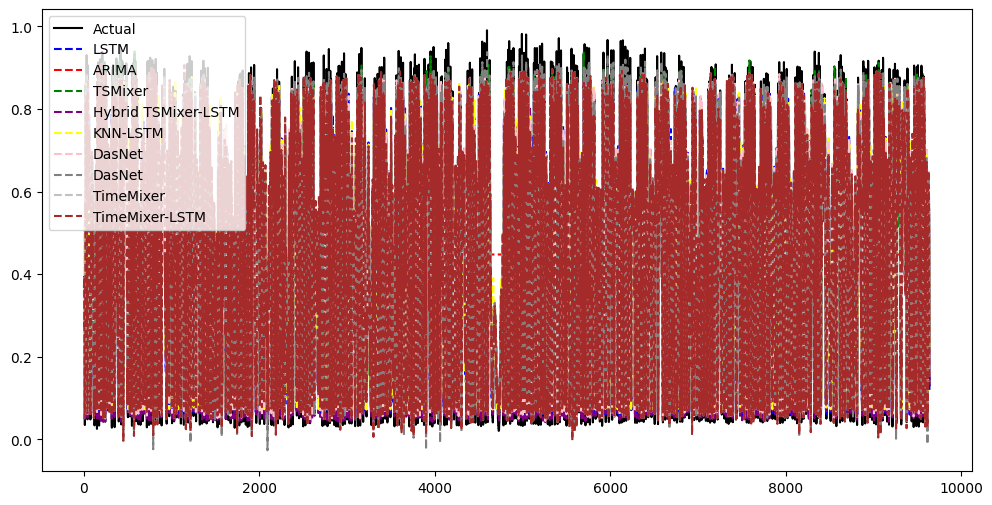

In [22]:
# ========================
# 6️⃣ PLOT MODEL PREDICTIONS
# ========================
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual_inv, label="Actual", color='black')
plt.plot(y_pred_lstm, label="LSTM", linestyle='dashed', color='blue')
plt.plot(y_pred_arima, label="ARIMA", linestyle='dashed', color='red')
plt.plot(y_pred_tsmixer, label="TSMixer", linestyle='dashed', color='green')
plt.plot( y_test_pred, label="Hybrid TSMixer-LSTM", linestyle='dashed', color='purple')
plt.plot(y_pred_knn_lstm, label="KNN-LSTM", linestyle='dashed', color='yellow')
plt.plot(y_pred_actual_Dasnet, label="DasNet", linestyle='dashed', color='pink')
plt.plot(y_pred_Dasnet_LSTM, label="DasNet", linestyle='dashed', color='grey')
plt.plot(y_pred_TimeMixer, label="TimeMixer", linestyle='dashed', color='silver')
plt.plot(y_pred_TimeMixer_LSTM, label="TimeMixer-LSTM", linestyle='dashed', color='brown')
plt.legend()
plt.show()



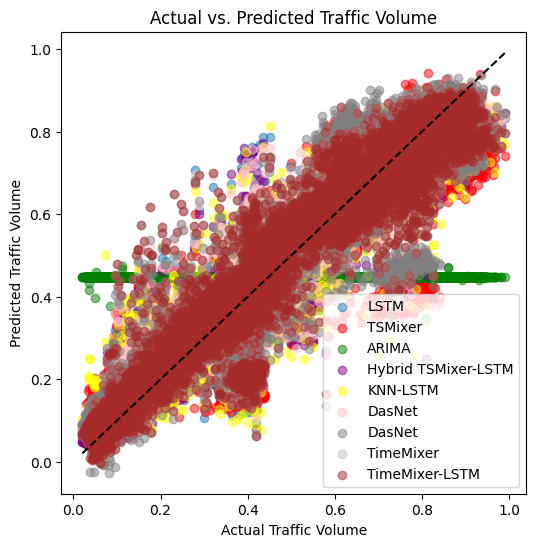

In [23]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_lstm, alpha=0.5, label="LSTM")
plt.scatter(y_test, y_pred_tsmixer, alpha=0.5, label="TSMixer", color='red')
plt.scatter(y_test, y_pred_arima, alpha=0.5, label="ARIMA", color='green')
plt.scatter(y_test, y_test_pred, alpha=0.5, label="Hybrid TSMixer-LSTM", color='purple')
plt.scatter(y_test, y_pred_knn_lstm, alpha=0.5, label="KNN-LSTM", color='yellow')
plt.scatter(y_test, y_pred_actual_Dasnet, alpha=0.5, label="DasNet", color='pink')
plt.scatter(y_test, y_pred_Dasnet_LSTM, alpha=0.5, label="DasNet", color='grey')
plt.scatter(y_test, y_pred_TimeMixer, alpha=0.5, label="TimeMixer", color='silver')
plt.scatter(y_test, y_pred_TimeMixer_LSTM, alpha=0.5, label="TimeMixer-LSTM", color='brown')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='black')  # Ideal fit line
plt.legend()
plt.title("Actual vs. Predicted Traffic Volume")
plt.xlabel("Actual Traffic Volume")
plt.ylabel("Predicted Traffic Volume")
plt.show()


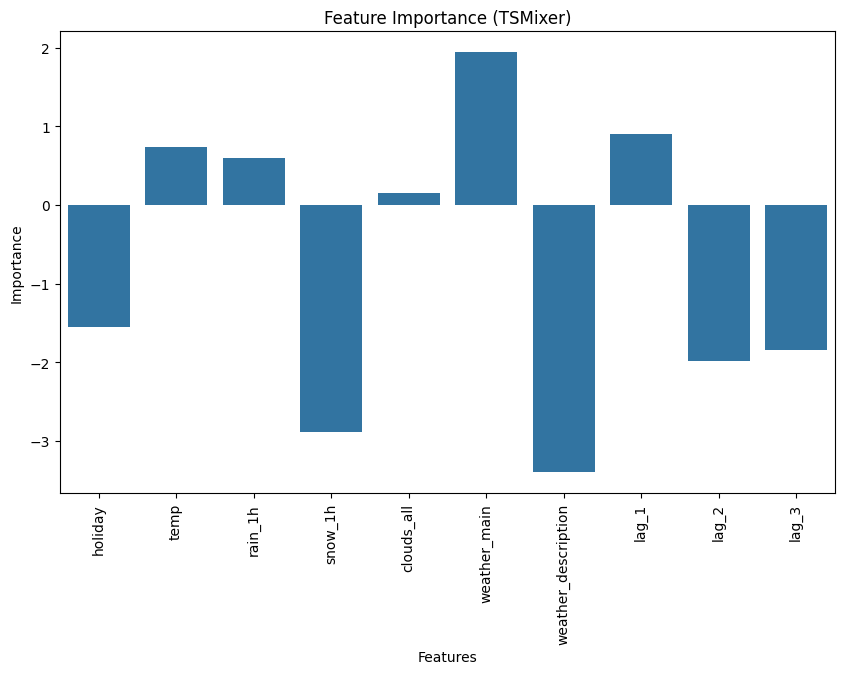

In [24]:
import seaborn as sns
importance = tsmixer_model.fc1.weight.detach().numpy().sum(axis=0)  # Example for TSMixer
plt.figure(figsize=(10, 6))
sns.barplot(x=X_train.columns, y=importance)
plt.xticks(rotation=90)
plt.title("Feature Importance (TSMixer)")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()

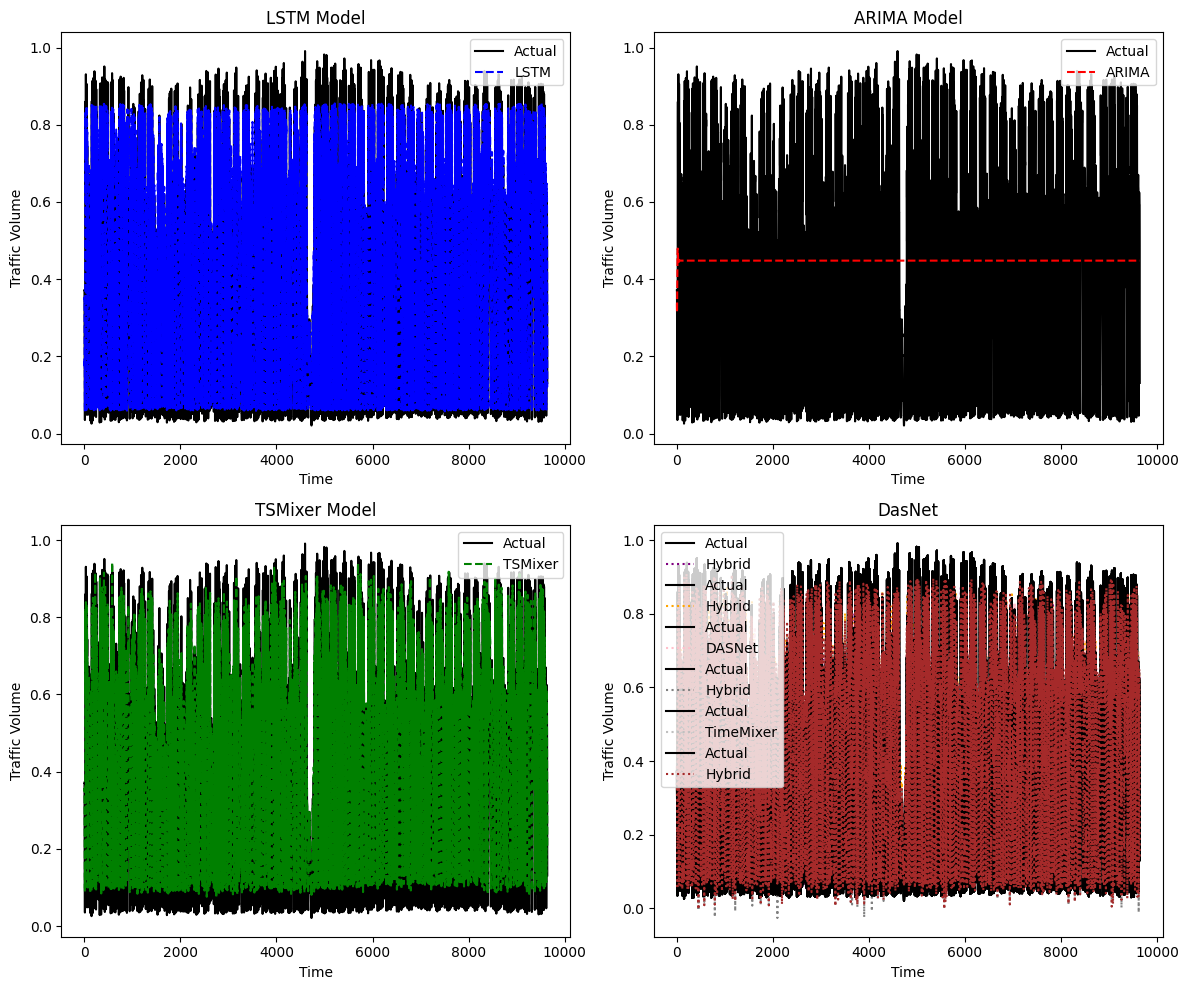

In [25]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0, 0].plot(y_test_actual_inv, label="Actual", color='black')
axes[0, 0].plot(y_pred_lstm, label="LSTM", linestyle='dashed', color='blue')
axes[0, 0].set_title("LSTM Model")

axes[0, 1].plot(y_test_actual_inv, label="Actual", color='black')
axes[0, 1].plot(y_pred_arima, label="ARIMA", linestyle='dashed', color='red')
axes[0, 1].set_title("ARIMA Model")

axes[1, 0].plot(y_test_actual_inv, label="Actual", color='black')
axes[1, 0].plot(y_pred_tsmixer, label="TSMixer", linestyle='dashed', color='green')
axes[1, 0].set_title("TSMixer Model")

axes[1, 1].plot(y_test_actual_inv, label="Actual", color='black')
axes[1, 1].plot(y_test_pred, label="Hybrid", linestyle='dotted', color='purple')
axes[1, 1].set_title("Hybrid TSMixer-LSTM")

axes[1, 1].plot(y_test_actual_inv, label="Actual", color='black')
axes[1, 1].plot(y_pred_knn_lstm, label="Hybrid", linestyle='dotted', color='orange')
axes[1, 1].set_title("KNN LTM")

axes[1, 1].plot(y_test_actual_inv, label="Actual", color='black')
axes[1, 1].plot(y_pred_actual_Dasnet, label="DASNet", linestyle='dotted', color='pink')
axes[1, 1].set_title("DasNet")


axes[1, 1].plot(y_test_actual_inv, label="Actual", color='black')
axes[1, 1].plot(y_pred_Dasnet_LSTM, label="Hybrid", linestyle='dotted', color='grey')
axes[1, 1].set_title("DasNet")

axes[1, 1].plot(y_test_actual_inv, label="Actual", color='black')
axes[1, 1].plot(y_pred_TimeMixer, label="TimeMixer", linestyle='dotted', color='silver')
axes[1, 1].set_title("TimeMixer")
axes[1, 1].plot(y_test_actual_inv, label="Actual", color='black')
axes[1, 1].plot(y_pred_TimeMixer_LSTM, label="Hybrid", linestyle='dotted', color='brown')
axes[1, 1].set_title("DasNet")




for ax in axes.flat:
    ax.legend()
    ax.set_xlabel("Time")
    ax.set_ylabel("Traffic Volume")

plt.tight_layout()
plt.show()


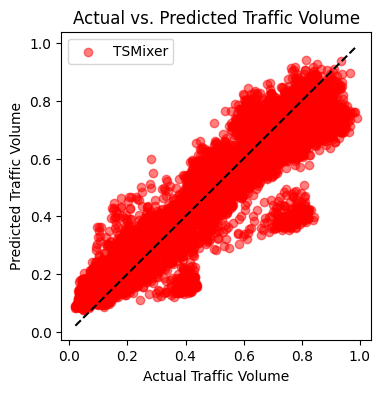

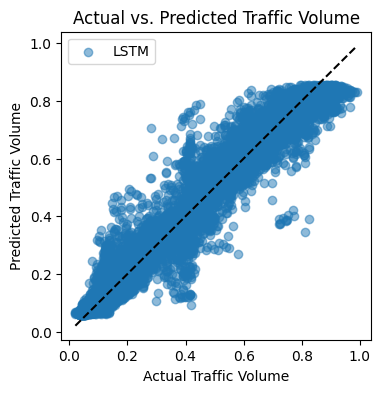

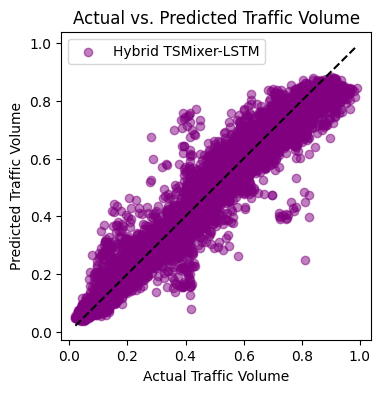

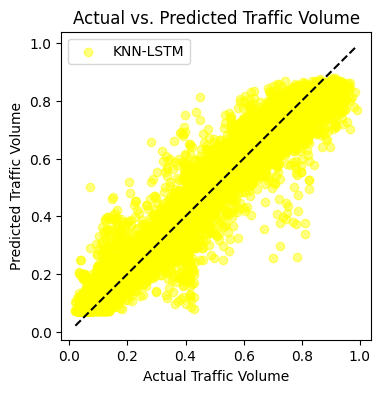

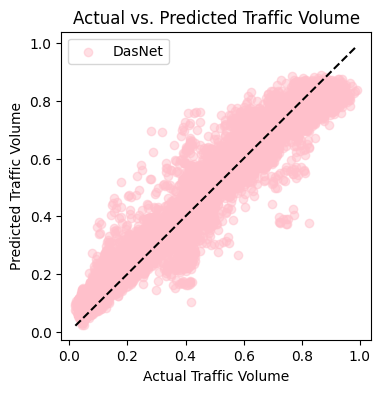

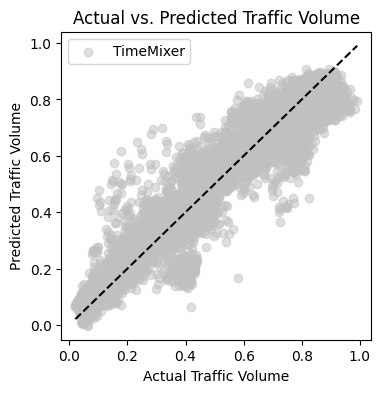

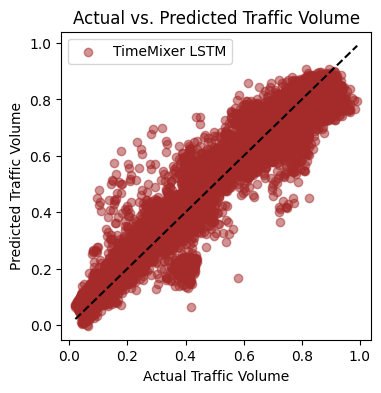

In [26]:
plt.figure(figsize=(4, 4))
plt.scatter(y_test, y_pred_tsmixer, alpha=0.5, label="TSMixer", color='red')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='black')  # Ideal fit line
plt.legend()
plt.title("Actual vs. Predicted Traffic Volume")
plt.xlabel("Actual Traffic Volume")
plt.ylabel("Predicted Traffic Volume")
plt.show()

plt.figure(figsize=(4, 4))
plt.scatter(y_test, y_pred_lstm, alpha=0.5, label="LSTM")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='black')  # Ideal fit line
plt.legend()
plt.title("Actual vs. Predicted Traffic Volume")
plt.xlabel("Actual Traffic Volume")
plt.ylabel("Predicted Traffic Volume")
plt.show()

plt.figure(figsize=(4, 4))
plt.scatter(y_test, y_test_pred, alpha=0.5, label="Hybrid TSMixer-LSTM", color='purple')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='black')  # Ideal fit line
plt.legend()
plt.title("Actual vs. Predicted Traffic Volume")
plt.xlabel("Actual Traffic Volume")
plt.ylabel("Predicted Traffic Volume")
plt.show()

plt.figure(figsize=(4, 4))
plt.scatter(y_test, y_pred_knn_lstm, alpha=0.5, label="KNN-LSTM", color='yellow')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='black')  # Ideal fit line
plt.legend()
plt.title("Actual vs. Predicted Traffic Volume")
plt.xlabel("Actual Traffic Volume")
plt.ylabel("Predicted Traffic Volume")
plt.show()

plt.figure(figsize=(4, 4))
plt.scatter(y_test, y_pred_actual_Dasnet, alpha=0.5, label="DasNet", color='pink')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='black')  # Ideal fit line
plt.legend()
plt.title("Actual vs. Predicted Traffic Volume")
plt.xlabel("Actual Traffic Volume")
plt.ylabel("Predicted Traffic Volume")
plt.show()

plt.figure(figsize=(4, 4))
plt.scatter(y_test, y_pred_TimeMixer, alpha=0.5, label="TimeMixer", color='silver')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='black')  # Ideal fit line
plt.legend()
plt.title("Actual vs. Predicted Traffic Volume")
plt.xlabel("Actual Traffic Volume")
plt.ylabel("Predicted Traffic Volume")
plt.show()


plt.figure(figsize=(4, 4))
plt.scatter(y_test, y_pred_TimeMixer_LSTM, alpha=0.5, label="TimeMixer LSTM", color='brown')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='black')  # Ideal fit line
plt.legend()
plt.title("Actual vs. Predicted Traffic Volume")
plt.xlabel("Actual Traffic Volume")
plt.ylabel("Predicted Traffic Volume")
plt.show()

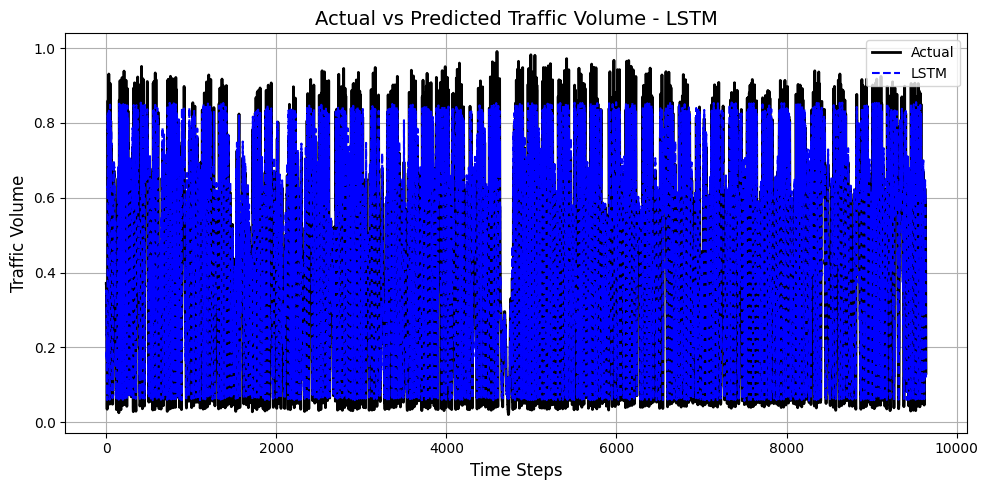

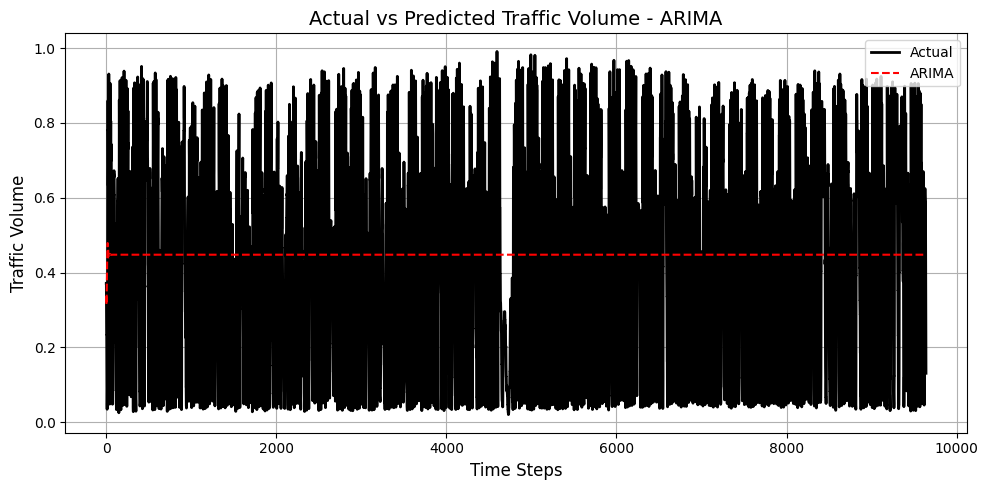

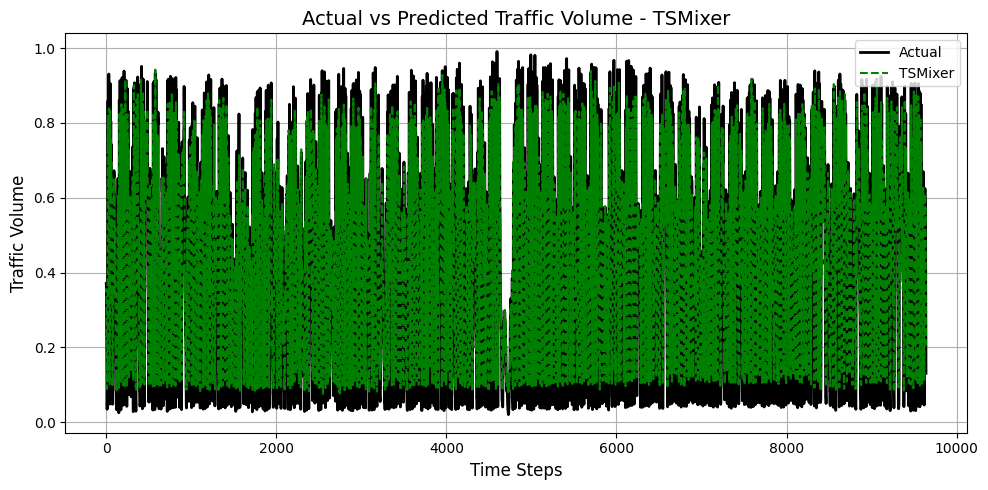

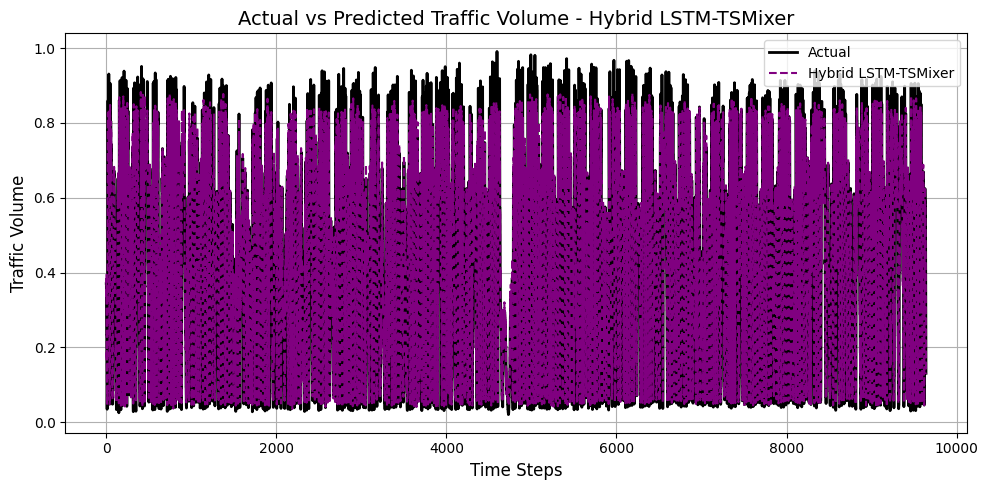

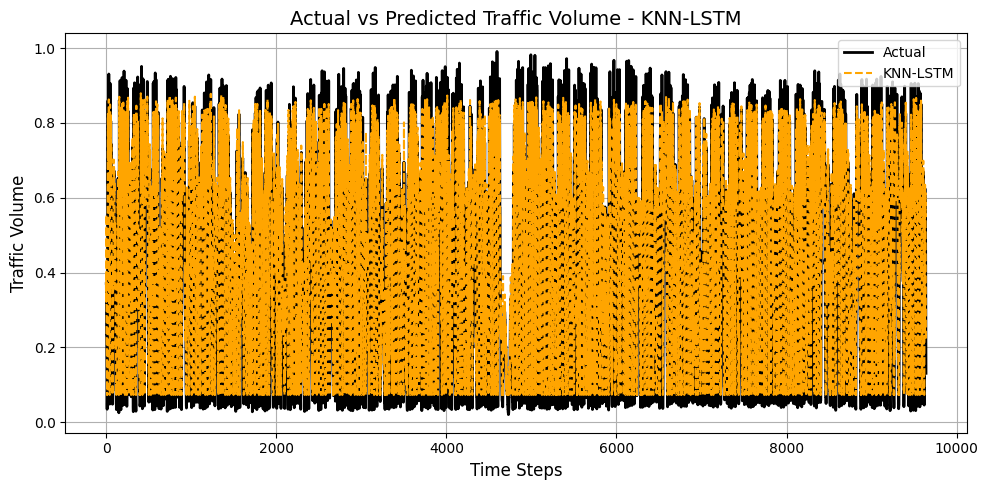

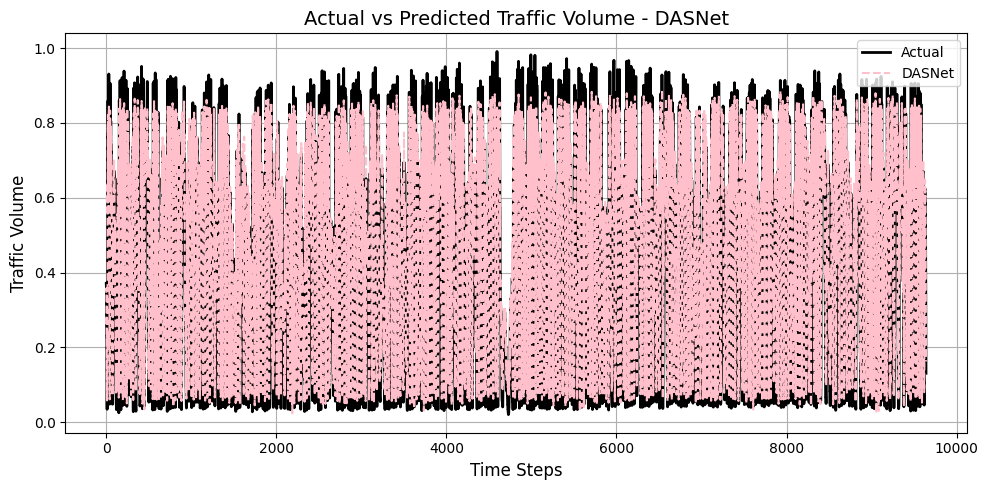

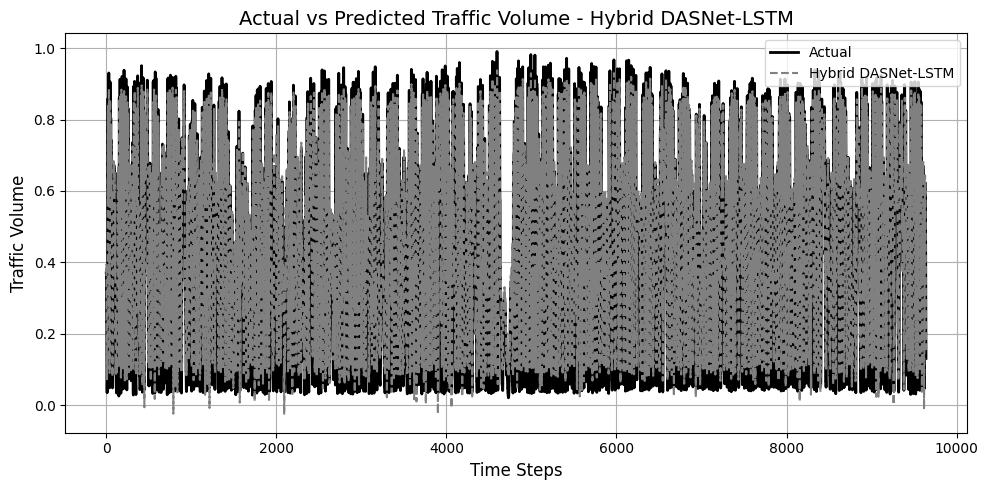

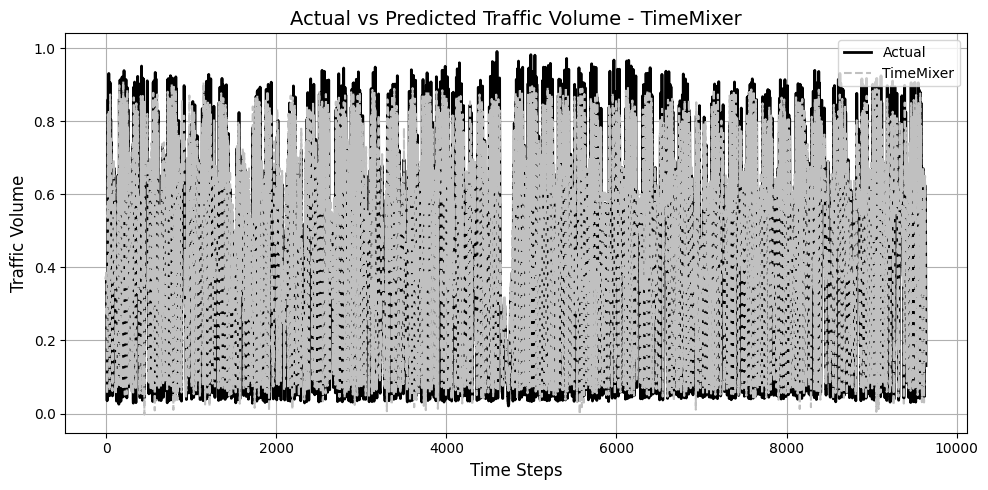

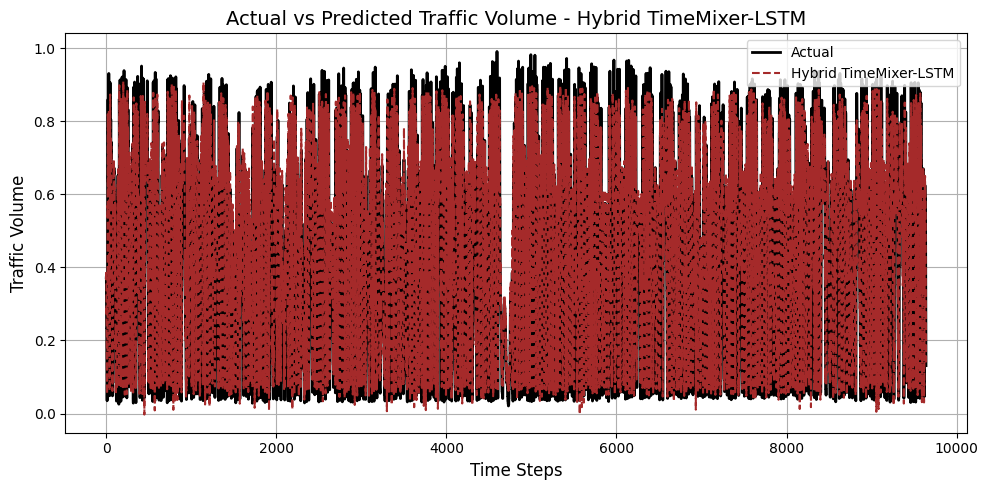

In [27]:
def plot_model_predictions(y_actual, y_pred, model_name, color='blue'):
    plt.figure(figsize=(10, 5))
    plt.plot(y_actual, label="Actual", color='black', linewidth=2)
    plt.plot(y_pred, label=model_name, linestyle='dashed', color=color)
    plt.title(f"Actual vs Predicted Traffic Volume - {model_name}", fontsize=14)
    plt.xlabel("Time Steps", fontsize=12)
    plt.ylabel("Traffic Volume", fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Call the function for each model
plot_model_predictions(y_test_actual_inv, y_pred_lstm, "LSTM", color='blue')
plot_model_predictions(y_test_actual_inv, y_pred_arima, "ARIMA", color='red')
plot_model_predictions(y_test_actual_inv, y_pred_tsmixer, "TSMixer", color='green')
plot_model_predictions(y_test_actual_inv, y_test_pred_inv, "Hybrid LSTM-TSMixer", color='purple')
plot_model_predictions(y_test_actual_inv, y_pred_knn_lstm, "KNN-LSTM", color='orange')
plot_model_predictions(y_test_actual_inv, y_pred_actual_Dasnet, "DASNet", color='pink')
plot_model_predictions(y_test_actual_inv, y_pred_Dasnet_LSTM, "Hybrid DASNet-LSTM", color='gray')
plot_model_predictions(y_test_actual_inv, y_pred_TimeMixer, "TimeMixer", color='silver')
plot_model_predictions(y_test_actual_inv, y_pred_TimeMixer_LSTM, "Hybrid TimeMixer-LSTM", color='brown')

In [28]:
# Display predicted vs actual values (first 10 entries) for each model using .iloc

def print_predictions(model_name, y_true, y_pred):
    print(f"\n📌 {model_name} Predictions (First 10 Samples)")
    print("-" * 50)
    for i in range(10):
        actual = y_true[i] if isinstance(y_true, np.ndarray) else y_true.iloc[i]
        print(f"Actual: {actual:.2f} | Predicted: {y_pred[i]:.2f}")

# Display predictions
print_predictions("LSTM", y_test_actual_inv, y_pred_lstm)
#print_predictions("ARIMA", y_test_actual_inv, y_pred_arima)
print_predictions("TSMixer", y_test_actual_inv, y_pred_tsmixer)
print_predictions("Hybrid LSTM-TSMixer", y_test_actual_inv, y_test_pred_inv)
print_predictions("KNN-LSTM", y_test_actual_inv, y_pred_knn_lstm.flatten())
print_predictions("DASNet", y_test_actual_inv, y_pred_actual_Dasnet.flatten())
print_predictions("Hybrid DASNet-LSTM", y_test_actual_inv, y_pred_Dasnet_LSTM.flatten())
print_predictions("TimeMixer", y_test_actual_inv, y_pred_TimeMixer.flatten())
print_predictions("Hybrid TimeMixer-LSTM", y_test_actual_inv, y_pred_TimeMixer_LSTM.flatten())



📌 LSTM Predictions (First 10 Samples)
--------------------------------------------------
Actual: 0.37 | Predicted: 0.34
Actual: 0.37 | Predicted: 0.35
Actual: 0.30 | Predicted: 0.35
Actual: 0.30 | Predicted: 0.25
Actual: 0.24 | Predicted: 0.26
Actual: 0.24 | Predicted: 0.17
Actual: 0.15 | Predicted: 0.20
Actual: 0.08 | Predicted: 0.09
Actual: 0.05 | Predicted: 0.07
Actual: 0.03 | Predicted: 0.06

📌 TSMixer Predictions (First 10 Samples)
--------------------------------------------------
Actual: 0.37 | Predicted: 0.36
Actual: 0.37 | Predicted: 0.35
Actual: 0.30 | Predicted: 0.36
Actual: 0.30 | Predicted: 0.30
Actual: 0.24 | Predicted: 0.27
Actual: 0.24 | Predicted: 0.23
Actual: 0.15 | Predicted: 0.21
Actual: 0.08 | Predicted: 0.15
Actual: 0.05 | Predicted: 0.10
Actual: 0.03 | Predicted: 0.09

📌 Hybrid LSTM-TSMixer Predictions (First 10 Samples)
--------------------------------------------------
Actual: 0.37 | Predicted: 0.36
Actual: 0.37 | Predicted: 0.33
Actual: 0.30 | Predicted: 0.39

#<p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#207d06; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #207d06;">**Explainable AI**</p>